In [1]:
import ribopy
from ribopy import Ribo
import pandas as pd
%matplotlib inline

In [2]:
ribo_path   = "all.ribo"
ribo_object = Ribo(ribo_path)

In [3]:
ribo_object.print_info()

Ribo File Info:
---------------
Ribo File Version : 1.0
RiboPy Version    : 0.0.1
Creation Time     : 2024-11-01 22:44:40
Reference         : appris-mouse-v1
Min Read Length   : 15
Max Read Length   : 50
Metagene Radius   : 50
Left Span         : 35
Right Span        : 10

Experiments:
------------ 
Name             Reads  Coverage  RNA-Seq  Metadata
GMP_Ven_A      2994442         *        *          
GMP_Ven_B      1261569         *        *          
GMP_vehicle_A  2101276         *        *          
GMP_vehicle_B  1974496         *        *          
HSC_Ven_A      3138251         *        *          
HSC_Ven_B       850656         *        *          
HSC_vehicle_A  2031132         *        *          
HSC_vehicle_B  1880303         *        *          


In [34]:
ribo_counts = None  

for region in ["UTR5", "UTR5_junction", "CDS", "UTR3_junction", "UTR3", ]:
    temp_counts = ribo_object.get_region_counts(
        experiments=ribo_object.experiments,
        region_name=region,
        range_lower=27,
        range_upper=34,
        sum_references=False,
        alias=False
    )
    
    if ribo_counts is None:
        ribo_counts = temp_counts
    else:
        ribo_counts += temp_counts 

ribo_counts.index = ribo_counts.index.str.split('|').str[5]
ribo_counts = ribo_counts.sort_index(axis=0)

In [75]:
rna_counts = ribo_object.get_rnaseq()
rna_counts['Reads'] = rna_counts.iloc[:, 2:].sum(axis=1)
rna_counts = rna_counts[['Reads']]
rna_counts = rna_counts.unstack(level=0)
rna_counts.index = rna_counts.index.str.split('|').str[5]
rna_counts = rna_counts.sort_index(axis=0)

rna_counts.columns = rna_counts.columns.get_level_values(1)
rna_counts.reset_index(inplace=True)
rna_counts.index = rna_counts["reference"]
rna_counts.drop(axis=1, columns="reference", inplace=True)

In [77]:
# ribo_counts.to_csv("ribo_counts.txt", sep="\t", index=True)
rna_counts.to_csv("rna_counts.txt", sep="\t", index=True)

In [25]:
def calculate_rpkm(raw_counts):
    norm_counts = pd.DataFrame(index=raw_counts.index)
    norm_counts['CDS_len'] = raw_counts.index.to_series().apply(lambda x: float(x.split('|')[6]))

    for col in raw_counts.columns:
        total_reads_sample = raw_counts[col].sum()
        
        # Calculate RPKM
        norm_counts[col] = raw_counts[col] / ((norm_counts['CDS_len'] / 1000) * (total_reads_sample / 1000000))
    norm_counts = norm_counts.drop(columns=['CDS_len'])
    return norm_counts

In [67]:
norm_ribo_counts = calculate_rpkm(ribo_counts)
norm_rna_counts = calculate_rpkm(rna_counts)

In [77]:
ribo_counts.to_csv('ribo_counts.txt', sep='\t', header=True, index=True)

In [20]:
def get_psite_offset(ribo_object, exp, mmin, mmax):
    """
    Calculates the P-site offsets for ribosome profiling experiments.

    Parameters:
        ribo_object (Ribo): The Ribo object containing ribosome profiling data.
        exp (str): The name of the experiment for which P-site offsets are calculated.
        mmin (int): The minimum read length considered for P-site offset calculation.
        mmax (int): The maximum read length considered for P-site offset calculation.

    Returns:
        dict: A dictionary mapping transcript identifiers to their respective P-site offsets.
    """
    df = (ribo_object.get_metagene("start", experiments=exp,\
                                   range_lower=mmin, range_upper=mmax,\
                                   sum_lengths=False,\
                                   sum_references=True))

    p_site = {}

    for index, row in df.iterrows():
        max_value_index = row.iloc[35:41].idxmax()
        offset = -1 * max_value_index + 1

        p_site[index[1]] = offset 
    return p_site

In [21]:
for exp in ribo_object.experiments:
    print(exp, "\n", get_psite_offset(ribo_object, exp, 25, 50))

GMP_Ven_A 
 {25: 11, 26: 14, 27: 14, 28: 11, 29: 13, 30: 14, 31: 14, 32: 14, 33: 11, 34: 14, 35: 14, 36: 14, 37: 14, 38: 14, 39: 14, 40: 14, 41: 14, 42: 14, 43: 14, 44: 14, 45: 14, 46: 14, 47: 14, 48: 14, 49: 14, 50: 14}
GMP_Ven_B 
 {25: 14, 26: 14, 27: 14, 28: 11, 29: 14, 30: 13, 31: 14, 32: 14, 33: 14, 34: 14, 35: 14, 36: 14, 37: 14, 38: 14, 39: 14, 40: 14, 41: 14, 42: 14, 43: 14, 44: 14, 45: 14, 46: 14, 47: 14, 48: 14, 49: 14, 50: 14}
GMP_vehicle_A 
 {25: 14, 26: 14, 27: 14, 28: 14, 29: 13, 30: 13, 31: 14, 32: 14, 33: 14, 34: 14, 35: 14, 36: 14, 37: 14, 38: 14, 39: 14, 40: 14, 41: 14, 42: 14, 43: 14, 44: 14, 45: 14, 46: 14, 47: 14, 48: 13, 49: 14, 50: 14}
GMP_vehicle_B 
 {25: 14, 26: 14, 27: 14, 28: 14, 29: 13, 30: 13, 31: 14, 32: 14, 33: 14, 34: 14, 35: 14, 36: 14, 37: 14, 38: 14, 39: 13, 40: 14, 41: 14, 42: 14, 43: 14, 44: 14, 45: 14, 46: 14, 47: 14, 48: 14, 49: 14, 50: 14}
HSC_Ven_A 
 {25: 15, 26: 14, 27: 14, 28: 11, 29: 11, 30: 13, 31: 14, 32: 14, 33: 11, 34: 11, 35: 14, 36: 14,

<Figure size 1500x1000 with 0 Axes>

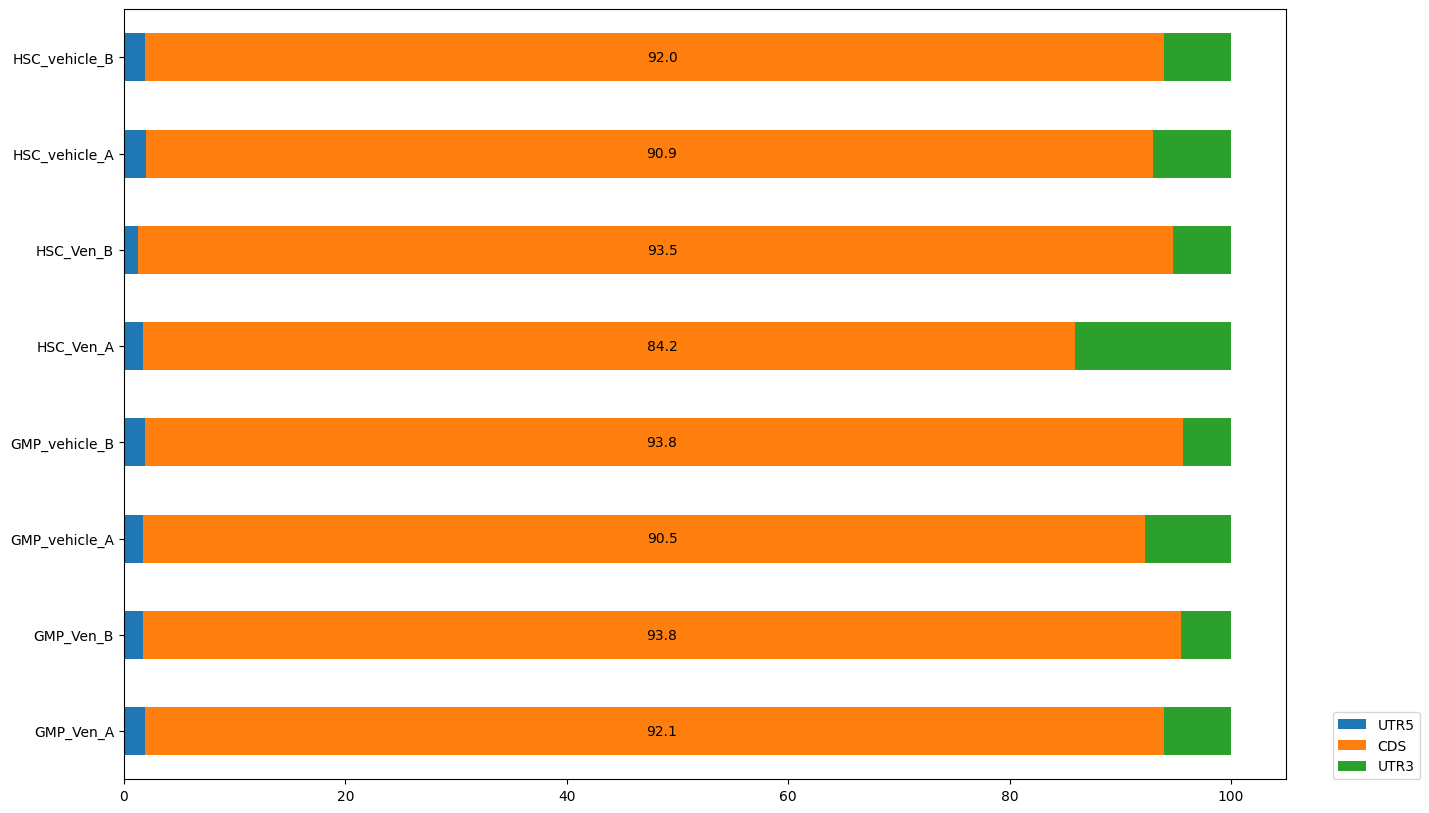

In [31]:
ribo_object.plot_region_counts(experiments = ribo_object.experiments,
                               range_lower = 31,
                               range_upper = 37,
                               horizontal  = True)

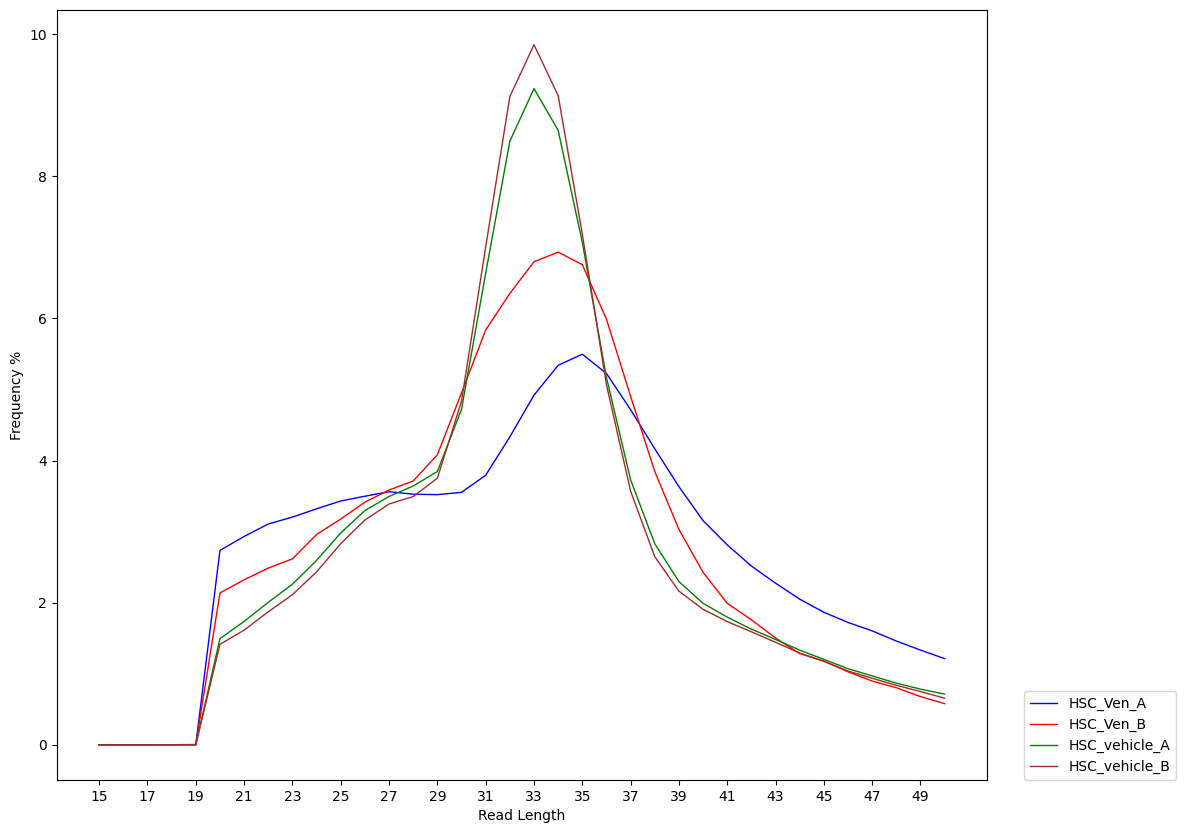

In [34]:
ribo_object.plot_lengthdist(region_type = "CDS",
                            normalize   = True,
                            experiments = ["HSC_Ven_A", "HSC_Ven_B", "HSC_vehicle_A", "HSC_vehicle_B"])

In [25]:
ribo_object.get_length_dist(region_name = "CDS")

,GMP_Ven_A,GMP_Ven_B,GMP_vehicle_A,GMP_vehicle_B,HSC_Ven_A,HSC_Ven_B,HSC_vehicle_A,HSC_vehicle_B
read_length,,,,,,,,
15,0,0,0,0,0,0,0,0
16,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0
18,1,1,1,1,2,0,1,1
19,13,4,17,7,33,6,13,20
20,13833,6553,15327,9689,65468,15507,24651,21838
21,16920,7911,18284,11904,70171,16851,28639,24938
22,20459,9805,21469,14812,74375,18047,33080,28928
23,24795,11735,24710,18722,76701,18992,37283,32641
